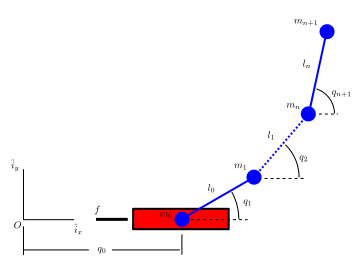

In [1]:
from IPython.display import SVG
SVG(filename='n-pendulum-with-cart.svg')

I used these software versions for the following computations:

- IPython: 0.13.1.rc2
- matplotlib: 1.1.1
- NumPy: 1.6.2
- SciPy: 0.10.1
- SymPy: 0.7.2
- python-control: 0.6d 

Equations of Motion
===================

We'll start by generating the equations of motion for the system with SymPy **[mechanics](http://docs.sympy.org/dev/modules/physics/mechanics/index.html)**. The functionality that mechanics provides is much more in depth than Mathematica's functionality. In the Mathematica example, Lagrangian mechanics were implemented manually with Mathematica's symbolic functionality. **mechanics** provides an assortment of functions and classes to derive the equations of motion for arbitrarily complex (i.e. configuration constraints, nonholonomic motion constraints, etc) multibody systems in a very natural way. First we import the necessary functionality from SymPy.

In [2]:
from sympy import symbols
from sympy.physics.mechanics import *

Now specify the number of links, $n$. I'll start with 5 since the Wolfram folks only showed four.

In [3]:
n = 5

**mechanics** will need the generalized coordinates, generalized speeds, and the input force which are all time dependent variables and the bob masses, link lengths, and acceleration due to gravity which are all constants. Time, $t$, is also made available because we will need to differentiate with respect to time.

In [4]:
q = dynamicsymbols('q:' + str(n + 1))  # Generalized coordinates
u = dynamicsymbols('u:' + str(n + 1))  # Generalized speeds
f = dynamicsymbols('f')                # Force applied to the cart
    
m = symbols('m:' + str(n + 1))         # Mass of each bob
l = symbols('l:' + str(n))             # Length of each link
g, t = symbols('g t')                  # Gravity and time

Now we can create and inertial reference frame $I$ and define the point, $O$, as the origin.

In [5]:
I = ReferenceFrame('I')                # Inertial reference frame
O = Point('O')                         # Origin point
O.set_vel(I, 0)                        # Origin's velocity is zero

Secondly, we define the define the first point of the pendulum as a particle which has mass. This point can only move laterally and represents the motion of the "cart".

In [6]:
P0 = Point('P0')                       # Hinge point of top link
P0.set_pos(O, q[0] * I.x)              # Set the position of P0    
P0.set_vel(I, u[0] * I.x)              # Set the velocity of P0
Pa0 = Particle('Pa0', P0, m[0])        # Define a particle at P0

Now we can define the $n$ reference frames, particles, gravitational forces, and kinematical differential equations for each of the pendulum links. This is easily done with a loop.

In [7]:
frames = [I]                              # List to hold the n + 1 frames
points = [P0]                             # List to hold the n + 1 points
particles = [Pa0]                         # List to hold the n + 1 particles
forces = [(P0, f * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f
kindiffs = [q[0].diff(t) - u[0]]          # List to hold kinematic ODE's

for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i + 1], I.z])   # Create a new frame
    Bi.set_ang_vel(I, u[i + 1] * I.z)                         # Set angular velocity
    frames.append(Bi)                                         # Add it to the frames list

    Pi = points[-1].locatenew('P' + str(i + 1), l[i] * Bi.x)  # Create a new point
    Pi.v2pt_theory(points[-1], I, Bi)                         # Set the velocity
    points.append(Pi)                                         # Add it to the points list
    
    Pai = Particle('Pa' + str(i + 1), Pi, m[i + 1])           # Create a new particle
    particles.append(Pai)                                     # Add it to the particles list

    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point
        
    kindiffs.append(q[i + 1].diff(t) - u[i + 1])              # Define the kinematic ODE:  dq_i / dt - u_i = 0

With all of the necessary point velocities and particle masses defined, the `KanesMethod` class can be used to derive the equations of motion of the system automatically.

In [8]:
kane = KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs) # Initialize the object
fr, frstar = kane.kanes_equations(forces, particles)     # Generate EoM's fr + frstar = 0

C:\Users\cdi\anaconda3\lib\site-packages\sympy\physics\mechanics\kane.py:528: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  SymPyDeprecationWarning(value='The API for kanes_equations() has changed such '


The equations of motion are quite long as can been seen below. This is the general nature of most non-simple mutlibody problems. That is why a SymPy is so useful; no more mistakes in algegra, differentiation, or copying in hand written equations. 

In [9]:
fr

Matrix([
[                                                                                                   f(t)],
[-g*l0*m1*cos(q1(t)) - g*l0*m2*cos(q1(t)) - g*l0*m3*cos(q1(t)) - g*l0*m4*cos(q1(t)) - g*l0*m5*cos(q1(t))],
[                     -g*l1*m2*cos(q2(t)) - g*l1*m3*cos(q2(t)) - g*l1*m4*cos(q2(t)) - g*l1*m5*cos(q2(t))],
[                                          -g*l2*m3*cos(q3(t)) - g*l2*m4*cos(q3(t)) - g*l2*m5*cos(q3(t))],
[                                                               -g*l3*m4*cos(q4(t)) - g*l3*m5*cos(q4(t))],
[                                                                                    -g*l4*m5*cos(q5(t))]])

In [10]:
frstar

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    l0*m1*u1(t)**2*cos(q1(t)) + l0*m2*u1(t)**2*cos(q1(t)) + l0*m3*u1(t)**2*cos(q1(t)) + l0*m4*u1(t)**2*cos(q1(t)) + l0*m5*u1(t)**2*cos(q1(t)) + l1*m2*u2(t)**2*cos(q2(t)) + l1*m3*u2(t)**2*cos(q2(t)) + l1*m4*u2(t)**2*cos(q2(t)) + l1*m5*u2(t)**2*cos(q2(t)) + l2*m3*u3(t)**2*cos(q3(t)) + l2*m4*u3(t)**2*cos

Simulation
==========

Now that the symbolic equations of motion are available we can simulate the pendulum's motion. We will need some more SymPy functionality and several NumPy functions, and most importantly the integration function from SciPy, `odeint`.

In [11]:
from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi
from numpy.linalg import solve
from scipy.integrate import odeint

First, define some numeric values for all of the constant parameters in the problem.

In [12]:
arm_length = 1. / n                          # The maximum length of the pendulum is 1 meter
bob_mass = 0.01 / n                          # The maximum mass of the bobs is 10 grams
parameters = [g, m[0]]                       # Parameter definitions starting with gravity and the first bob
parameter_vals = [9.81, 0.01 / n]            # Numerical values for the first two
for i in range(n):                           # Then each mass and length
    parameters += [l[i], m[i + 1]]            
    parameter_vals += [arm_length, bob_mass]

Mathematica has a really nice `NDSolve` function for quickly integrating their symbolic differential equations. We have plans to develop something similar for SymPy but haven't found the development time yet to do it properly. So the next bit isn't as clean as we'd like but you can make use of SymPy's lambdify function to create functions that will evaluate the mass matrix, $M$, and forcing vector, $\bar{f}$ from $M\dot{u} = \bar{f}(q, \dot{q}, u, t)$ as a NumPy function. We make use of dummy symbols to replace the time varying functions in the SymPy equations a simple dummy symbol. 

In [25]:
dynamic = q + u                                                # Make a list of the states
dynamic.append(f)                                              # Add the input force
dummy_symbols = [Dummy() for i in dynamic]                     # Create a dummy symbol for each variable
dummy_dict = dict(zip(dynamic, dummy_symbols))                 
kindiff_dict = kane.kindiffdict()                              # Get the solved kinematical differential equations
M = kane.mass_matrix_full.subs(kindiff_dict).subs(dummy_dict)  # Substitute into the mass matrix 
F = kane.forcing_full.subs(kindiff_dict).subs(dummy_dict)      # Substitute into the forcing vector
M_func = lambdify(dummy_symbols + parameters, M)               # Create a callable function to evaluate the mass matrix 
F_func = lambdify(dummy_symbols + parameters, F)               # Create a callable function to evaluate the forcing vector 

In [34]:
F_func

<function _lambdifygenerated(Dummy_928, Dummy_927, Dummy_926, Dummy_925, Dummy_924, Dummy_923, Dummy_922, Dummy_921, Dummy_920, Dummy_919, Dummy_918, Dummy_917, Dummy_916, Dummy_915, Dummy_909, Dummy_914, Dummy_908, Dummy_913, Dummy_907, Dummy_912, Dummy_906, Dummy_911, Dummy_905, Dummy_910, _Dummy_904)>

To integrate the ODE's we need to define a function that returns the derivatives of the states given the current state and time.

In [14]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    u = 0.0                              # The input force is always zero     
    arguments = hstack((x, u, args))     # States, input, and parameters
    dx = array(solve(M_func(*arguments), # Solving for the derivatives
        F_func(*arguments))).T[0]
    
    return dx

In [15]:
from numpy import *
from matplotlib.pyplot import *

Now that we have the right hand side function, the initial conditions are set such that the pendulum is in the vertical equilibrium and a slight initial rate is set for each speed to ensure the pendulum falls. The equations can then be integrated with SciPy's `odeint` function given a time series.

In [16]:
x0 = hstack(( 0, pi / 2 * ones(len(q) - 1), 1e-3 * ones(len(u)) )) # Initial conditions, q and u
t = linspace(0, 10, 1000)                                          # Time vector
y = odeint(right_hand_side, x0, t, args=(parameter_vals,))         # Actual integration

Plotting
========

The results of the simulation can be plotted with matplotlib.

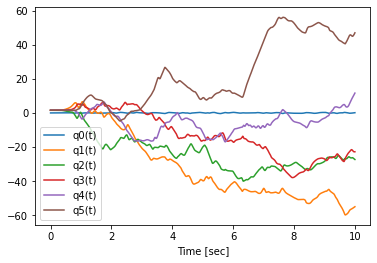

In [17]:
lines = plot(t, y[:,:int(y.shape[1]/2)])
lab = xlabel('Time [sec]')
leg = legend(dynamic[:int(y.shape[1]/2)])

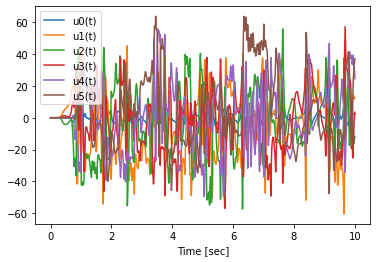

In [18]:
lines = plot(t, y[:,6:])
lab = xlabel('Time [sec]')
leg = legend(dynamic[6:])

Animation
=========

matplotlib now includes very nice animation functions for animating matplotlib plots. First we import the necessary functions for creating the animation.

In [19]:
from numpy import zeros, cos, sin, arange, around
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle

The following function was modeled from Jake Vanderplas's [post on matplotlib animations](http://jakevdp.github.com/blog/2012/08/18/matplotlib-animation-tutorial/).

In [20]:
def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = int(states.shape[1] / 2)

    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some dimesions
    cart_width = 0.4
    cart_height = 0.2
    
    # set the limits based on the motion
    xmin = around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = around(states[:, 0].max() + cart_width / 2.0, 1)
    
    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)
    
    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
        cart_width, cart_height, fill=True, color='red', ec='black')
    ax.add_patch(rect)
    
    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = hstack((states[i, 0], zeros((numpoints - 1))))
        y = zeros((numpoints))
        for j in arange(1, numpoints):
            x[j] = x[j - 1] + length * cos(states[i, j])
            y[j] = y[j - 1] + length * sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')

Now we can create the animation of the pendulum. This animation will show the open loop dynamics.

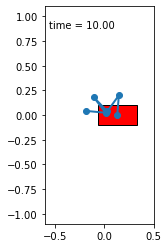

In [21]:
#animate_pendulum(t, y, arm_length, filename="open-loop.ogv")
animate_pendulum(t, y, arm_length, filename="open-loop.mp4")

In [22]:
from IPython.display import HTML
h = \
"""
<video width="640" height="480" controls>
  <source src="files/open-loop.ogv" type="video/ogg">
  <source src="files/open-loop.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTuve version instead: http://youtu.be/Nj3_npq7MZI.
</video>
"""
HTML(h)

Controller Design
=================

The n-link pendulum can be balanced such that all of the links are inverted above the cart by applying the correct lateral force to the cart. We can design a full state feedback controller based off of a linear model of the pendulum about its upright equilibrium point. We'll start by specifying the equilibrium point and parameters in dictionaries.

In [23]:
equilibrium_point = hstack(( 0, pi / 2 * ones(len(q) - 1), zeros(len(u)) ))
equilibrium_dict = dict(zip(q + u, equilibrium_point))
parameter_dict = dict(zip(parameters, parameter_vals))

The `KanesMethod` class has method that linearizes the forcing vector about generic state and input perturbation vectors. The equilibrium point and numerical constants can then be substituted in to give the linear system in this form: $M\dot{x}=F_Ax+F_Bu$. The state and input matrices, $A$ and $B$, can then be computed by left side multiplication by the inverse of the mass matrix: $A=M^{-1}F_A$ and $B=M^{-1}F_B$.

In [24]:
# symbolically linearize about arbitrary equilibrium
linear_state_matrix, linear_input_matrix, inputs = kane.linearize()
# sub in the equilibrium point and the parameters
f_A_lin = linear_state_matrix.subs(parameter_dict).subs(equilibrium_dict)
f_B_lin = linear_input_matrix.subs(parameter_dict).subs(equilibrium_dict)
m_mat = kane.mass_matrix_full.subs(parameter_dict).subs(equilibrium_dict)
# compute A and B
from numpy import matrix
A = matrix(m_mat.inv() * f_A_lin)
B = matrix(m_mat.inv() * f_B_lin)

ValueError: too many values to unpack (expected 3)

Now that we have a linear system, the python-control package can be used to design an optimal controller for the system.

In [ ]:
import control
from numpy import dot, rank
from numpy.linalg import matrix_rank

First we can check to see if the system is, in fact, controllable.

In [ ]:
assert matrix_rank(control.ctrb(A, B)) == A.shape[0]

The control matrix is full rank, so now we can compute the optimal gains with a linear quadratic regulator. I chose identity matrices for the weightings for simplicity.

In [ ]:
K, X, E = control.lqr(A, B, ones(A.shape), 1);

The gains can now be used to define the required input during simulation to stabilize the system. The input $u$ is simply the gain vector multiplied by the error in the state vector from the equilibrium point, $u(t)=K(x_{eq} - x(t))$.

In [ ]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    u = dot(K, equilibrium_point - x)    # The controller     
    arguments = hstack((x, u, args))     # States, input, and parameters
    dx = array(solve(M_func(*arguments), # Solving for the derivatives
        F_func(*arguments))).T[0]
    
    return dx

Now we can simulate and animate the system to see if the controller works.

In [ ]:
x0 = hstack(( 0, pi / 2 * ones(len(q) - 1), 1 * ones(len(u)) )) # Initial conditions, q and u
t = linspace(0, 10, 1000)                                       # Time vector
y = odeint(right_hand_side, x0, t, args=(parameter_vals,))      # Actual integration

The plots show that we seem to have a stable system.

In [ ]:
lines = plot(t, y[:, :y.shape[1] / 2])
lab = xlabel('Time [sec]')
leg = legend(dynamic[:y.shape[1] / 2])

In [ ]:
lines = plot(t, y[:, y.shape[1] / 2:])
lab = xlabel('Time [sec]')
leg = legend(dynamic[y.shape[1] / 2:])

In [ ]:
animate_pendulum(t, y, arm_length, filename="closed-loop.ogv")
animate_pendulum(t, y, arm_length, filename="closed-loop.mp4")

In [ ]:
from IPython.display import HTML
h = \
"""
<video width="640" height="480" controls>
  <source src="files/closed-loop.ogv" type="video/ogg">
  <source src="files/closed-loop.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/SpgBHqW9om0
</video>
"""
HTML(h)

The video clearly shows that our controller can balance all $n$ of the pendulum links. The weightings in the lqr design can be tweaked to give different performance if needed.

This example shows that the free and open source scientific Python tools for dynamics are easily comparable in ability and quality a commercial package such as Mathematica. Besides the current installation hurdles for Python, I'd like to claim that it may better than commercial packages, due to our much more robust SymPy **mechanics** package and the fact that all of the code is liberally licensed for reuse and hacking.

The IPython notebook for this example can be downloaded from https://github.com/gilbertgede/idetc-2013-paper/blob/master/n-pendulum-control.ipynb. Yo ucan try out different $n$ values. I've gotten the equations of motion to compute and an open loop simulation of 10 links. My computer ran out of memory when I tried to compute for $n=50$. The controller weightings and initial conditions will probably have to be adjusted for better performance for $n>5$, but it should work. Let me know the resuls if you play with it.